In [2]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm import tqdm


In [3]:
torch.manual_seed(420)

In [18]:
DATASET_ROOT = 'dataset'
A_DIR = os.path.join(DATASET_ROOT, 'a')
B_DIR = os.path.join(DATASET_ROOT, 'b')
C_DIR = os.path.join(DATASET_ROOT, 'c')
D_DIR = os.path.join(DATASET_ROOT, 'd')

DOG_CLASS_INDEX = 12  # VOC dog class index

In [5]:

item_c_imgs = [os.path.join(C_DIR, fname) for fname in os.listdir(C_DIR) if fname.lower().endswith('.jpg')]

# Item D: test images and masks
item_d_imgs = sorted([os.path.join(D_DIR, fname) for fname in os.listdir(D_DIR) if fname.lower().endswith('.jpg')])
item_d_masks = [img.replace('.jpg', '_mask.png') for img in item_d_imgs]

In [6]:
pseudo_label_dir = 'pseudo_labels'

In [7]:
ORIG_DIR = 'orig'  

likely_dog_imgs = [os.path.join(ORIG_DIR, fname)
                   for fname in os.listdir(ORIG_DIR)
                   if fname.lower().endswith('.jpg')]

In [8]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        # For pseudo-labels from SAM, just threshold
        mask = np.array(mask)
        mask = np.where(mask > 127, 1, 0).astype(np.uint8)
        mask = Image.fromarray(mask)
        inputs = self.processor(images=image, segmentation_maps=mask, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        return inputs

In [9]:
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
pseudo_label_paths = [os.path.join(pseudo_label_dir, os.path.basename(img).replace('.jpg', '_mask.png')) for img in likely_dog_imgs]
dataset = PseudoLabeledDataset(likely_dog_imgs, pseudo_label_paths, processor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

/home/scai/mtech/aib242289/.conda/envs/cv/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [10]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b5-finetuned-ade-640-640",
    num_labels=2,  # Background & dog
    ignore_mismatched_sizes=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model.train()
for epoch in range(10):  # Adjust epochs as needed
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].long().to(device)
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())


Epoch 15: 100%|██████████████████| 60/60 [00:26<00:00,  2.26it/s, loss=0.000191]


In [12]:
model.save_pretrained(os.path.join(DATASET_ROOT, "finetuned_segformer_dog"))
processor.save_pretrained(os.path.join(DATASET_ROOT, "finetuned_segformer_dog"))


['dataset/finetuned_segformer_dog/preprocessor_config.json']

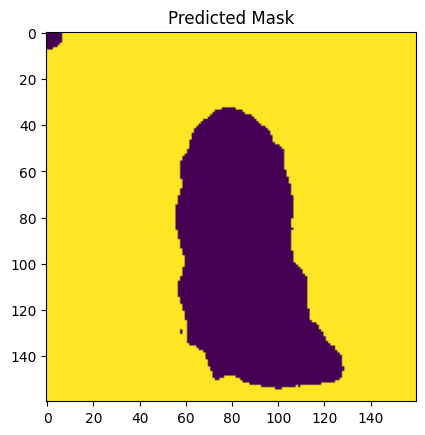

In [13]:
model.eval()
with torch.no_grad():
    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = outputs.logits.argmax(dim=1)
        break

plt.imshow(preds[0].cpu().numpy())
plt.title("Predicted Mask")
plt.show()

In [14]:
from torchvision.transforms import functional as F

def compute_iou(pred_mask, true_mask, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        true_inds = (true_mask == cls)
        intersection = (pred_inds & true_inds).sum().item()
        union = (pred_inds | true_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # Ignore this class
        else:
            ious.append(intersection / union)
    return ious

def pixel_accuracy(pred_mask, true_mask):
    correct = (pred_mask == true_mask).sum().item()
    total = true_mask.numel()
    return correct / total

def evaluate(model, img_list, mask_list, processor, device):
    model.eval()
    iou_list = []
    pixel_acc_list = []
    image_metrics = []  # To store (img_path, iou, pixel_acc)

    with torch.no_grad():
        for img_path, mask_path in zip(img_list, mask_list):
            image = Image.open(img_path).convert("RGB")
            true_mask = Image.open(mask_path)
            true_mask = np.array(true_mask)
            # Binarize for dog class (12)
            true_mask = np.where(true_mask == DOG_CLASS_INDEX, 0, 1).astype(np.uint8)
            
            # Print unique values in ground truth mask
            #print(f"Ground Truth Mask ({os.path.basename(mask_path)}): Unique values = {np.unique(true_mask)}")

            true_mask_tensor = torch.tensor(true_mask, dtype=torch.int64)
            inputs = processor(images=image, return_tensors="pt")
            pixel_values = inputs.pixel_values.to(device)
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            pred_mask = torch.argmax(logits.squeeze(), dim=0).cpu()

            # Print unique values in predicted mask
            #print(f"Predicted Mask ({os.path.basename(img_path)}): Unique values = {np.unique(pred_mask.numpy())}")

            # Resize true mask to match prediction if needed
            if true_mask_tensor.shape != pred_mask.shape:
                true_mask_pil = Image.fromarray(true_mask_tensor.numpy().astype(np.uint8))
                true_mask_resized = F.resize(true_mask_pil, pred_mask.shape, interpolation=Image.NEAREST)
                true_mask_tensor = torch.tensor(np.array(true_mask_resized), dtype=torch.int64)

            # Compute metrics
            ious = compute_iou(pred_mask, true_mask_tensor, num_classes=2)
            iou_list.append(ious)
            pixel_acc = pixel_accuracy(pred_mask, true_mask_tensor)
            pixel_acc_list.append(pixel_acc)

            image_metrics.append({
                "img_path": img_path,
                "iou": ious[1],  # IoU for class 1 (dog)
                "pixel_acc": pixel_acc
            })

    # Compute mean IoU ignoring NaNs
    iou_array = np.array(iou_list)
    mean_iou_per_class = np.nanmean(iou_array, axis=0)
    mean_iou = np.nanmean(mean_iou_per_class)
    mean_pixel_acc = np.mean(pixel_acc_list)
    return {
        "miou": mean_iou,
        "miou_per_class": mean_iou_per_class.tolist(),
        "pixel_acc": mean_pixel_acc,
        "image_metrics": image_metrics  # Add per-image results
    }

metrics = evaluate(model, item_d_imgs, item_d_masks, processor, device)
print("mIoU:", metrics['miou'], "Pixel Accuracy:", metrics['pixel_acc'])

# %%
# Visualize Item A and a few test images/mask

mIoU: 0.5582425058766955 Pixel Accuracy: 0.7238180541992187


# After calling evaluate()
metrics = evaluate(model, item_d_imgs, item_d_masks, processor, device)
print("mIoU:", metrics['miou'], "Pixel Accuracy:", metrics['pixel_acc'])

# Extract and sort images by IoU
image_metrics_sorted = sorted(
    metrics['image_metrics'], 
    key=lambda x: x['iou'], 
    reverse=True
)

# Get top N images (e.g., top 5)
top_n = 30
top_images = image_metrics_sorted[:top_n]

# Print results
print("\nTop images by IoU:")
for entry in top_images:
    print(f"IoU: {entry['iou']:.4f} | Image: {entry['img_path']}")


import matplotlib.pyplot as plt
from PIL import Image

def show_img_gt_pred(img_path, mask_path, model, processor, device):
    # Load image and ground truth mask
    img = Image.open(img_path).convert("RGB")
    gt_mask = Image.open(mask_path)
    
    # Prepare input and get model prediction
    inputs = processor(images=img, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        pred_mask = torch.argmax(outputs.logits.squeeze(), dim=0).cpu().numpy()
    
    # Plot all three
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(gt_mask); plt.title('Ground Truth'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_mask); plt.title('Predicted Mask'); plt.axis('off')
    plt.show()

# For each entry in top_images, plot the results
for entry in top_images:
    img_path = entry['img_path']
    mask_path = img_path.replace('.jpg', '_mask.png')  # Assuming this naming convention
    print(f"IoU: {entry['iou']:.4f} | Image: {img_path}")
    show_img_gt_pred(img_path, mask_path, model, processor, device)


import matplotlib.pyplot as plt
from PIL import Image
import torch

def show_img_gt_pred(img_path, mask_path, model, processor, device):
    # Load image and ground truth mask
    img = Image.open(img_path).convert("RGB")
    gt_mask = Image.open(mask_path)
    
    # Prepare input and get model prediction
    inputs = processor(images=img, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        pred_mask = torch.argmax(outputs.logits.squeeze(), dim=0).cpu().numpy()
    
    # Plot all three
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(gt_mask); plt.title('Ground Truth'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_mask); plt.title('Predicted Mask'); plt.axis('off')
    plt.show()

# Example: visualize Item A
show_img_gt_pred(item_a_img, item_a_mask, model, processor, device)

# Example: visualize first 5 test images
for img_path, mask_path in zip(item_d_imgs[:5], item_d_masks[:5]):
    show_img_gt_pred(img_path, mask_path, model, processor, device)
